Sato1095
G*** M***

1. Συλλογή δεδομένων

In [42]:
import yfinance as yf
import pandas as pd    
import numpy as np

# Επιλογή μετοχής και ημερομηνιών (π.χ. για την KDP, 5 ημέρες πριν τις τελευταίες 2)
ticker = yf.Ticker('KDP')
start_date = '2025-05-12'
end_date = '2025-05-17'

# Λήψη δεδομένων ανά 30 λεπτά
data = ticker.history(period='1d', interval='30m', start=start_date, end=end_date)
   
# Αποθήκευση σε CSV
data.to_csv('KDP_30min_data.csv')
data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-05-12 09:30:00-04:00,33.869900,33.869900,33.259998,33.490002,1061813,0.0,0.0
2025-05-12 10:00:00-04:00,33.490002,33.494999,33.150002,33.209999,1267042,0.0,0.0
2025-05-12 10:30:00-04:00,33.205002,33.320000,33.154999,33.235001,350952,0.0,0.0
2025-05-12 11:00:00-04:00,33.230000,33.270000,33.174999,33.250000,381532,0.0,0.0
2025-05-12 11:30:00-04:00,33.255001,33.320000,33.185001,33.185001,333264,0.0,0.0


Υλοποίηση μεθόδων υπολογισμού πολυωνύμου, ΜΑΕ και MSE

In [43]:
# Μέθοδος για υπολογισμό πολυωνύμου
def Polynomial(input, coeff, degree):
    sum = 0
    for i in range(0, degree+1):
        sum += coeff[i]*input**(degree-i)   
    return sum


In [44]:
"""
Μέθοδος για υπολογισμό Mεan Absolute Error MAE
Υπολογίζει το μέσο απόλυτο σφάλμα μεταξύ πραγματικών και προβλεπόμενων τιμών
start: αρχή της λίστας, finish: τέλος της λίστας
real_output: πραγματικές τιμές, pred_output: προβλεπόμενες τιμές
"""
def MAE(start, finish, real_output, pred_output):
    sum = 0
    for i in range(start, finish):
        sum = sum + abs(real_output[i] - pred_output[i])
    return sum/(finish-start)

In [45]:
"""
Μέθοδος για υπολογισμό Mean Squared Error (MSE)
Υπολογίζει το μέσο τετραγωνικό σφάλμα μεταξύ πραγματικών και προβλεπόμενων τιμών
start: αρχή της λίστας, finish: τέλος της λίστας
real_output: πραγματικές τιμές, pred_output: προβλεπόμενες τιμές
"""
def MSE(start, finish, real_output, pred_output):
    sum = 0
    for i in range(start, finish):
        sum = sum + (real_output[i] - pred_output[i])**2
    return sum/(finish-start)

2. Πολυωνυμική Προσαρμογή Ελαχίστων Τετραγώνων

In [46]:
import numpy as np
# Ορίζω μεταβλητή prices που είναι ο πίνακας με τις τιμές κλεισίματος
prices = data['Close'].values.flatten()
# Ορίζω μεταβλητή time που είναι ο πίνακας με τους δείκτες των τιμών
time = np.arange(len(prices)) + 1

# Ορίζω μεταβλητή index80prcnt που είναι το 80% του μήκους του πίνακα time
index80prcnt = int(0.8 * len(time))
"""
Χωρίζω τα δεδομένα σε training και test set
80% training set και 20% test set  
"""         
time_trainingtimes = time[:index80prcnt]      #Πίνακας με δείκτες από το 0% ως το 80%
time_testtimes = time[index80prcnt:]          # Πίνακας με δείκτες από το 80% ως το 100%
price_train = prices[:index80prcnt]           # Πίνακας με τις πραγματικές τιμές από το 0% ως το 80%
price_test = prices[index80prcnt:]            # Πίνακας με τις πραγματικές τιμές από το 80% ως το 100% 

"""
Υπολογισμός συντελεστών πολυωνύμων και εισαγωγή τους σε πίνακα
coeffpowr[0]: συντελεστές 1ου βαθμού, coeffpowr[1]: συντελεστές 2ου βαθμού, coeffpowr[2]: συντελεστές 3ου βαθμού
np.polyfit: υπολογίζει τους συντελεστές του πολυωνύμου που προσεγγίζει τα δεδομένα
"""
coeffpowr = [
    np.polyfit(time_trainingtimes, price_train, i) for i in range(1, 4)
]

# Γενικό μοντέλο πολυωνύμων βαθμών 1, 2, 3
Polynomial_model = np. zeros((len(time), 3))
for i in range(0, len(time)):
    Polynomial_model[i] = [
        Polynomial(time[i], coeffpowr[j], j+1) for j in range(3)
    ]


# Υπολογισμός MAE για το training set
MAE_train = [
    MAE(0, len(time_trainingtimes), price_train, Polynomial_model[:index80prcnt, i]) for i in range(3)
]

# Υπολογισμός MSE για το training set
MSE_train = [
    MSE(0, len(time_trainingtimes), price_train, Polynomial_model[:index80prcnt, i]) for i in range(3)
]

# Υπολογισμός MAE για το test set
MAE_test = [
    MAE(0, len(time_testtimes), price_test, Polynomial_model[index80prcnt:, i]) for i in range(3)
]

# Υπολογισμός MSE για το test set
MSE_test = [
    MSE(0, len(time_testtimes), price_test, Polynomial_model[index80prcnt:, i]) for i in range(3)
]

# Εκτύπωση αποτελεσμάτων
print("MAE for training set: ")
for i in range(3):
    
    print(f"MAE for {i+1} degree polynomial: ", MAE_train[i])

print("MSE for training set: ")
for i in range(3):
    print(f"MSE for {i+1} degree polynomial: ", MSE_train[i])

print("MAE for test set: ")
for i in range(3):
    print(f"MAE for {i+1} degree polynomial: ", MAE_test[i])

print("MSE for test set: ")
for i in range(3):
    print(f"MSE for {i+1} degree polynomial: ", MSE_test[i])


MAE for training set: 
MAE for 1 degree polynomial:  0.2301059509241363
MAE for 2 degree polynomial:  0.21729675556946446
MAE for 3 degree polynomial:  0.15298573528549098
MSE for training set: 
MSE for 1 degree polynomial:  0.08470860935377805
MSE for 2 degree polynomial:  0.06466292791629241
MSE for 3 degree polynomial:  0.032253784768261344
MAE for test set: 
MAE for 1 degree polynomial:  0.7252578093760648
MAE for 2 degree polynomial:  0.13379264709287936
MAE for 3 degree polynomial:  1.3987322028329727
MSE for test set: 
MSE for 1 degree polynomial:  0.5379350611725342
MSE for 2 degree polynomial:  0.023543980763454767
MSE for 3 degree polynomial:  2.573254830664403


Απάντηση Ερώτησης Θεωρείας Άσκησης 2


Ένα πολυώνυμο υψηλότερου βαθμού, θα προσαρμοστεί πολύ καλά - ως μια πιο σύνθετη συνάρτηση - στα σημεία του training sample. Αυτό όμως δεν είναι ιδανικό, γιατί σημαίνει ότι θα προσαρμοστεί και θα εστιάσει περισσότερο από ότι είναι χρήσιμο και σε σημεία τα οποία θα να είναι ανωμαλίες ή θόρυβος στο δείγμα. Έτσι, το πολυώνυμο στη διαμόρφωση του θα λάβει "κατά πολύ" υπόψη τα outliers σημεία και άρα θα κάνει προβλέψεις που αποκλίνουν πολύ απ' τις πραγματικές τιμές. 
Μπορούμε να εντοπίσουμε αριθμητικά το overfitting συγκρίνοντας τις πραγματικές επόμενες τιμές π.χ. μιας μετοχής, με τις τιμές τις οποίες το overfitted μοντέλο προβλέπει, έτσι ώστε να παρατηρήσουμε πως θα έχουμε πολύ μεγάλο σφάλμα.,
Για αντιμετώπιση του overfitting, μπορούμε να αυξήσουμε τον αριθμό των σημείων στο training sample, για να "επικεντρωθεί" λιγότερο το μοντέλο σε ανωμαλίες. Μπορούμε να μειώσουμε τη πολυπλοκότητα του μοντέλου, να εφαρμόσουμε τεχνικές regularisation που θα δίνουν λιγότερη βαρύτητα σε ανωμαλίες στη δημιουργία του μοντέλου, ή ακόμα και να πειράξουμε το data sample ώστε να αφαιρέσουμε ανώμαλα σημεία που θα χειροτέρευαν τη ποιότητα του μοντέλου πρόβλεψης μας.


3. Πρόβλεψη Επόμενης Ημέρας

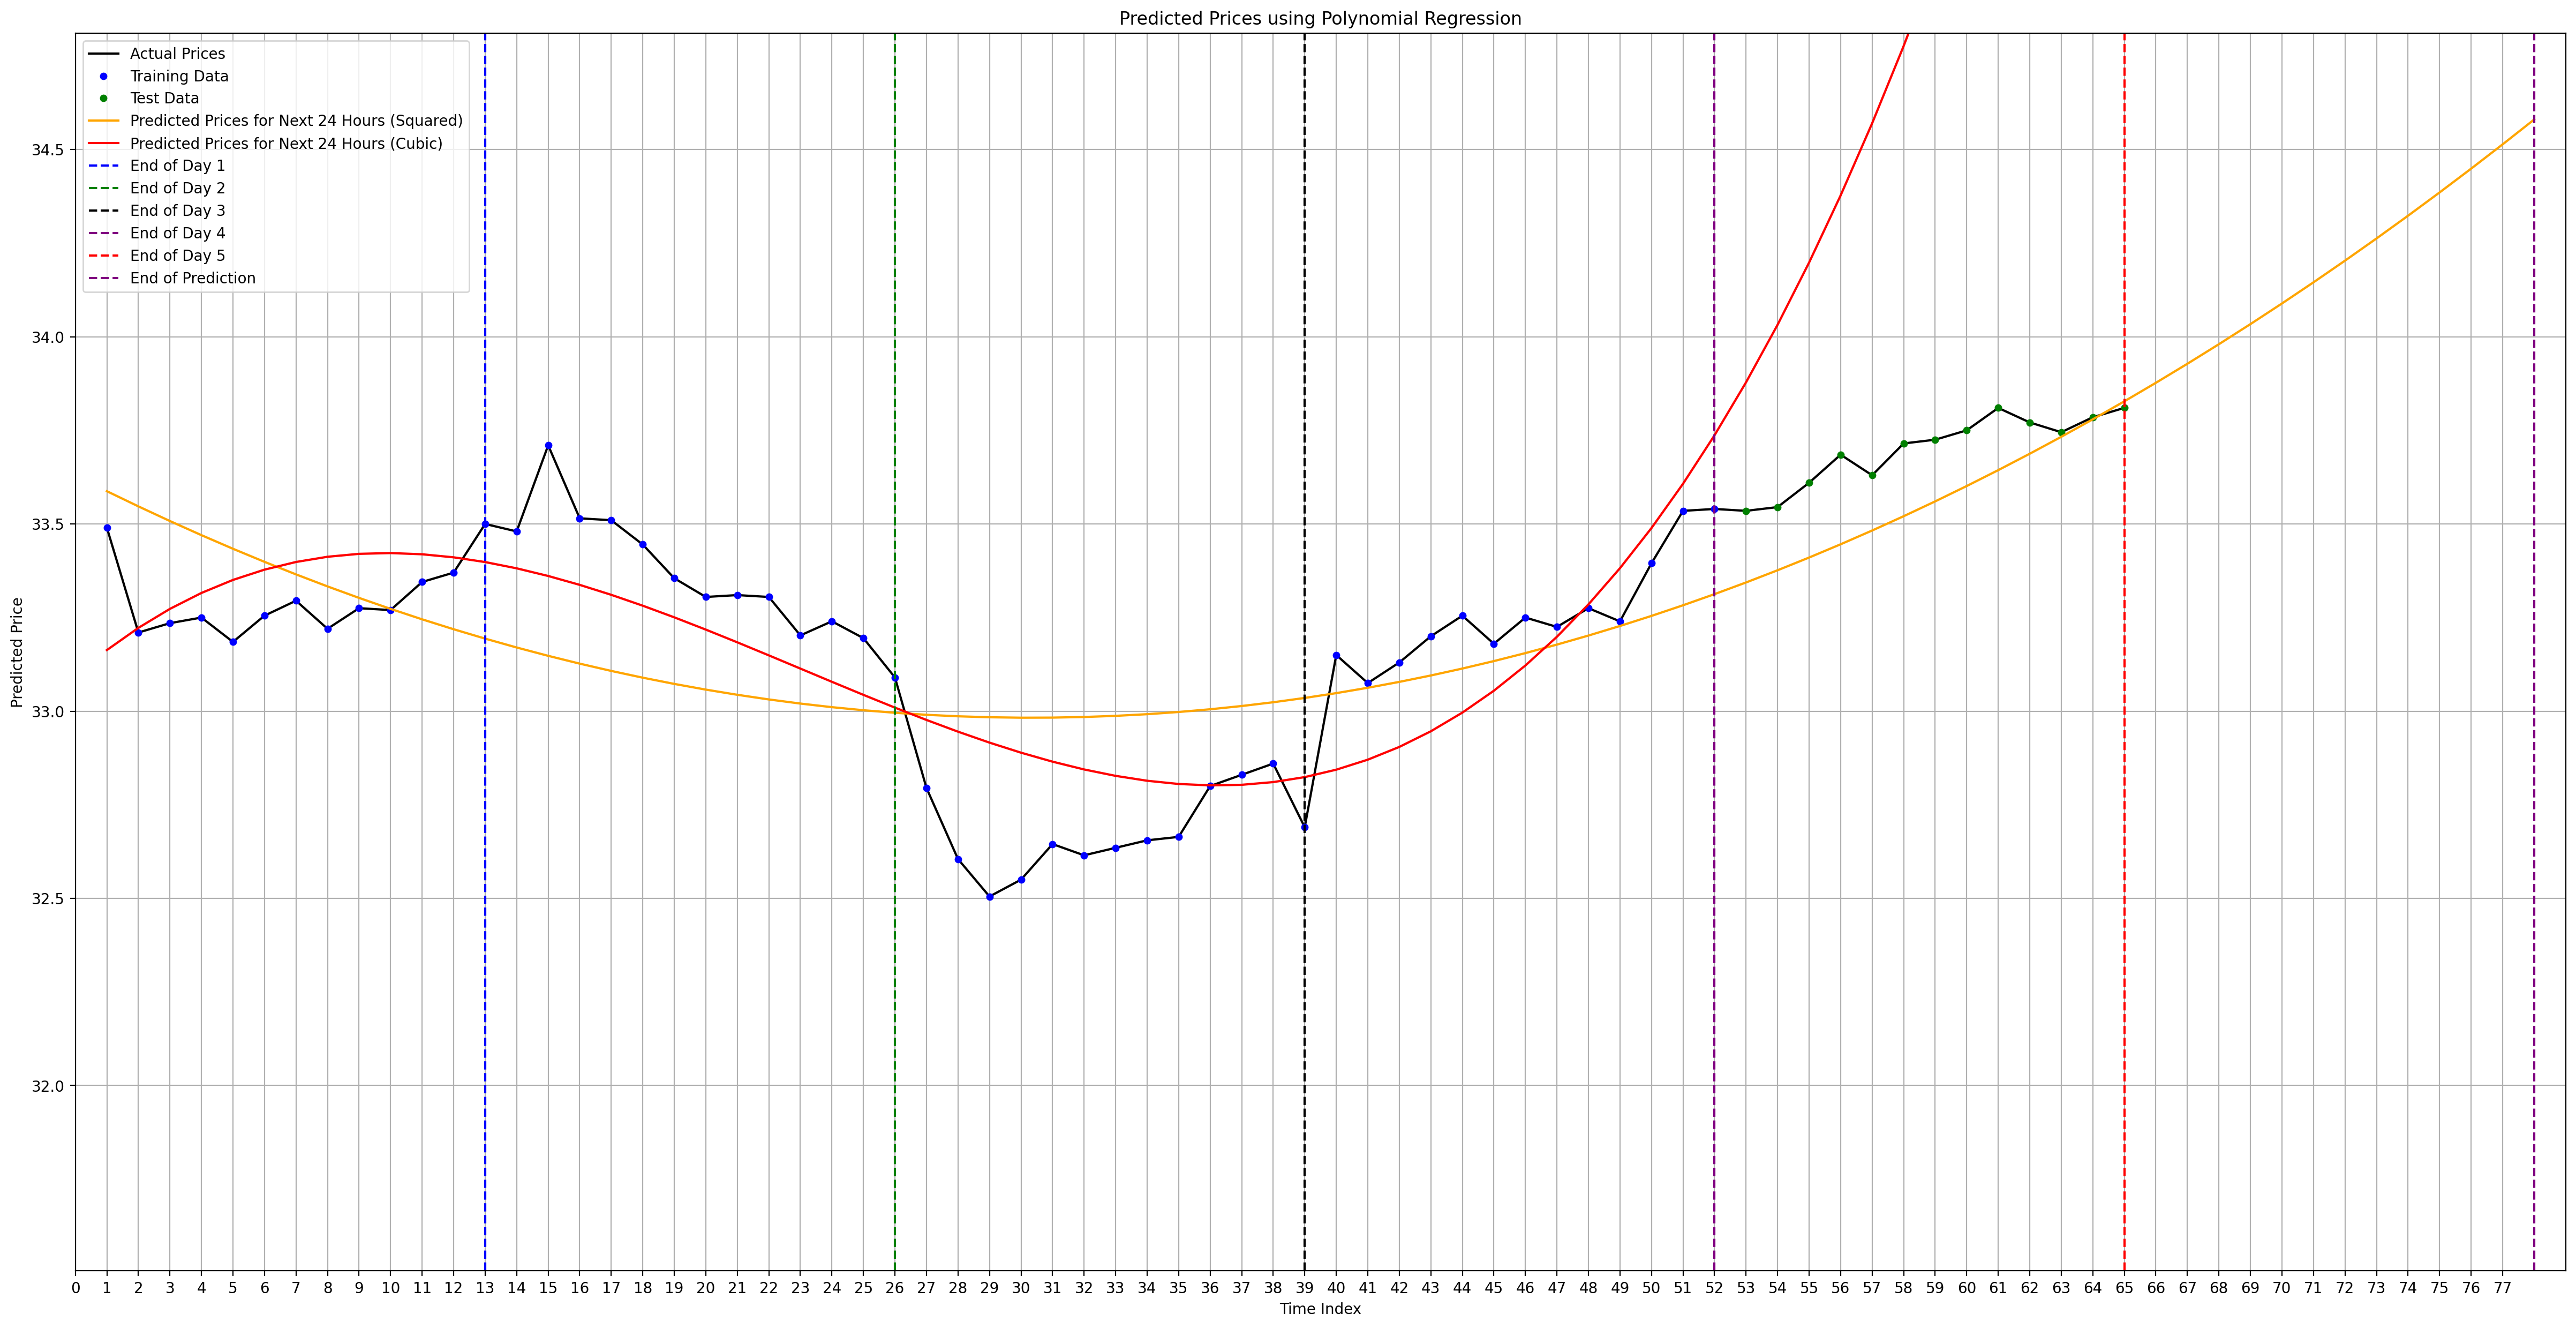

    Time Index  Predicted Price
0            1        33.587483
1            2        33.546935
2            3        33.507793
3            4        33.470058
4            5        33.433729
..         ...              ...
73          74        34.323186
74          75        34.385296
75          76        34.448813
76          77        34.513736
77          78        34.580065

[78 rows x 2 columns]


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

new_time_index = len(time) + int(len(time)/5)
time_new = np.arange(new_time_index) + 1
prediction_model_new_sq = np.zeros(new_time_index)  
prediction_model_new_cb = np.zeros(new_time_index)

# Υπολογισμός προβλέψεων για τις επόμενες 24 ώρες με πολυώνυμο 2ου βαθμού
for i in range(0, new_time_index):
    prediction_model_new_sq[i] = Polynomial(time_new[i], coeffpowr[1], 2)  
    prediction_model_new_cb[i] = Polynomial(time_new[i], coeffpowr[2], 3)

# Δημιουργία γραφήματος με τις προβλέψεις
plt.figure(figsize=(30,15), dpi=200)
plt.plot(time, prices, label='Actual Prices', color='black')
plt.plot(time_trainingtimes, price_train, 'o', label='Training Data', markersize=4, color='blue')
plt.plot(time_testtimes, price_test, 'o', label='Test Data', markersize=4, color='green')
plt.plot(time_new, prediction_model_new_sq, label='Predicted Prices for Next 24 Hours (Squared)', color='orange')
plt.plot(time_new, prediction_model_new_cb, label='Predicted Prices for Next 24 Hours (Cubic)', color='red')
plt.legend()
plt.title('Predicted Prices using Polynomial Regression')
plt.xlabel('Time Index')
plt.ylabel('Predicted Price')
color = ['blue', 'green', 'black', 'purple', 'red']
for i in range(1, 6):
    plt.axvline(x=13*i, color = color[i-1], linestyle='--', label=f'End of Day {i}')
plt.axvline(x=new_time_index, color='purple', linestyle='--', label='End of Prediction')
plt.xticks(np.arange(0, new_time_index, step=1))
plt.xlim(0, new_time_index+1)
plt.ylim(np.min(prices)-1, np.max(prices)+1)
plt.legend()
plt.grid(True)
plt.show()

# Αποθήκευση των προβλέψεων σε CSV
predictions_df = pd.DataFrame({'Time Index': time_new, 'Predicted Price': prediction_model_new_sq})
predictions_df.to_csv('Predicted_prices_next_24_hours.csv', index=False)

# Εκτύπωση των προβλέψεων
print(predictions_df)


Απάντηση Ερώτησης Θεωρείας Άσκησης 3

Η επιλογή πολυωνύμων διαφορετικού βαθμού έχει μεγάλο αντίκτυπο στις προβλέψεις του μοντέλου. Ένα απλό μοντέλο πχ πολυώνυμο 1ου βαθμού, θα είναι μια γραμμή, και αυτό σημαίνει ότι όσο και πολύπλοκη να είναι η πραγματικότητα των τιμών που μελεταμε (πχ να χρειάζεται διάφορες καμπύλες για να προσομοιωθεί σε συνάρτηση) θα τις προσομοιώσει με μια γραμμή, και θα έχουμε έτσι ένα ανακριβές μοντέλο με προγνώσεις μικρής αξίας (underfitting). Όπως περιγράψαμε και στο ερώτημα 2, η αντίθετη διαδικασία (overfitting) μπορεί να προκύψει αν επιλέξουμε ένα πολυώνυμο μεγαλυτερου βαθμού. Άρα, η επιλογή του κατάλληλου βαθμού πολυωνύμου (ούτε πολύ μικρού ούτε πολύ μεγάλου) είναι βασική.
Για να ελεγξουμε αν η πρόβλεψη είναι ασταθής, μπορούμε να κάνουμε μικρές αλλαγές στις τιμές του training συνόλου και να δούμε αν η πρόβλεψη των επόμενων σημείων είναι πολύ διαφορετική από την προηγούμενη. Αν η πρόβλεψη διαφέρει πολύ, ενώ το training σύνολο άλλαξε ελάχιστα, τότε η πρόβλεψη μας είναι ασταθής.

Υλοποιήση μεθόδων Κανόνα Τραπεζίου και Κανόνα του Simpson

In [48]:
def TrapezoidalRule(a, b, N, f):
    h = (b - a) / N
    sum = f[0] + f[N]
    for i in range(1, N):
        sum += 2 * f[i]
    return (h / 2) * sum

def SimpsonRule(a, b, N, f):
    h = 2*(b - a) / N
    sum = f[0] + f[N]
    for i in range(1, N, 2):
        sum += 4 * f[i]
    for i in range(2, N-1, 2):
        sum += 2 * f[i]
    return (h / 6) * sum

4. Ολοκλήρωση της Καμπύλης Τιμών για Μέση Τιμή

In [49]:
"""
Υπολογισμός του εμβαδού κάτω από την καμπύλη
με τη μέθοδο του Trapezoidal Rule και Simpson's Rule
"""
IntegralTrpzd = TrapezoidalRule(0, len(time), len(time)-1, prices)
IntegralSimps = SimpsonRule(0, len(time), len(time)-1, prices)

IntegralTrpzdPoly = [
    TrapezoidalRule(0, len(time), len(time)-1, Polynomial_model[:, i]) for i in range(0, 3)
]

IntegralSimpsPoly = [
    SimpsonRule(0, len(time), len(time)-1, Polynomial_model[:, i]) for i in range(0, 3)
]

print("Area under the curve using Trapezoidal Rule: ", IntegralTrpzd)
for i in range(0, 3):
    print(f"Area under the Polynomial of degree {i+1} curve using the Trapezoidal Rule: ", IntegralTrpzdPoly[i])
print("Area under the curve using Simpson's Rule: ", IntegralSimps)
for i in range(0, 3):
    print(f"Area under the Polynomial of degree {i+1} curve using the Simpson Rule: ", IntegralSimpsPoly[i])

slice = int(len(time))
MeanIntegralTrpzd = IntegralTrpzd / slice
MeanIntegralSimps = IntegralSimps / slice
print("Mean stock value using Trapezoidal Rule: ", MeanIntegralTrpzd)
for i in range(0, 3):
    print(f"Mean stock value using Trapezoidal Rule given by the Polynomial of degree {i+1} curve: ", IntegralTrpzdPoly[i]/slice)
print("Mean stock value using Simpson's Rule: ", MeanIntegralSimps)
for i in range(0, 3):
    print(f"Mean stock value using Simpson Rule given by the Polynomial of degree {i+1} curve: ", IntegralSimpsPoly[i]/slice)




Area under the curve using Trapezoidal Rule:  2161.5824189782143
Area under the Polynomial of degree 1 curve using the Trapezoidal Rule:  2152.548954844078
Area under the Polynomial of degree 2 curve using the Trapezoidal Rule:  2159.7930539460235
Area under the Polynomial of degree 3 curve using the Trapezoidal Rule:  2178.776937545247
Area under the curve using Simpson's Rule:  2161.665330330531
Area under the Polynomial of degree 1 curve using the Simpson Rule:  2152.5489548440783
Area under the Polynomial of degree 2 curve using the Simpson Rule:  2159.7854365968105
Area under the Polynomial of degree 3 curve using the Simpson Rule:  2178.754971077667
Mean stock value using Trapezoidal Rule:  33.25511413812637
Mean stock value using Trapezoidal Rule given by the Polynomial of degree 1 curve:  33.11613776683197
Mean stock value using Trapezoidal Rule given by the Polynomial of degree 2 curve:  33.22758544532344
Mean stock value using Trapezoidal Rule given by the Polynomial of degre

Απάντηση Ερώτησης Θεωρείας Άσκησης 4:

Με τους κανόνες τραπεζιού και Simpson, υπολογίζουμε προσεγγιστικά το εμβαδόν κάτω από μια συνάρτηση. Ο ακριβής υπολογισμός του χωριού με μηδενικό σφάλμα συμβαίνει μόνο όταν υπολογίζουμε το ολοκλήρωμα της συνάρτησης στο διάστημα που έχουμε, το οποίο δεν είναι παρά ένα άθροισμα απλων εμβαδών σε άπειρα απείρως μικρά step sizes. Οπότε, μικραίνοντας το step size, οι κανόνες μας "πλησιάζουν" πιο πολύ το ολοκλήρωμα, αυξάνοντας έτσι την ακρίβεια του υπολογισμενου εμβαδού.

Υλοποίηση μεθόδου πολυωνύμων παρεμβολής Newton και μεθόδου διηρημένης διαφοράς

In [50]:
"""
Μέθοδος για  υπολογισμό πολυωνύμου παρεμβολής Newton
"""
def NewtonInterpolationPoly(input, x, coeff):           # Το input είναι το x της συνάρτησης 
    sum = coeff[0]
    prd = 0
    for i in range(1, len(x)):
        prd = 1
        for j in range(0, i):
            prd *= (input - x[j]) 
        sum += coeff[i] * prd 
    return sum

In [51]:
"""
Μέθοδος για υπολογισμό των συντελεστών του πολυωνύμου
με τη μέθοδο της διηρημένου διαφοράς
"""
def DivDiffCoeff(x, y):
    n = len(y)
    coeff = np.zeros((n, n))
    coeff[:, 0] = y
    for j in range(1, n):
        for i in range(n-j):                                                    # Αφού κάθε διαδικασία έχει ένα λιγότερο στοιχείο από την προηγούμενη
            coeff[i][j] = (coeff[i+1][j-1] - coeff[i][j-1]) / (x[i+j] - x[i])
    return coeff[0]

5. Ανίχνευση Ανωμαλιών στα Ιστορικά Δεδομένα - Μέθοδος Newton

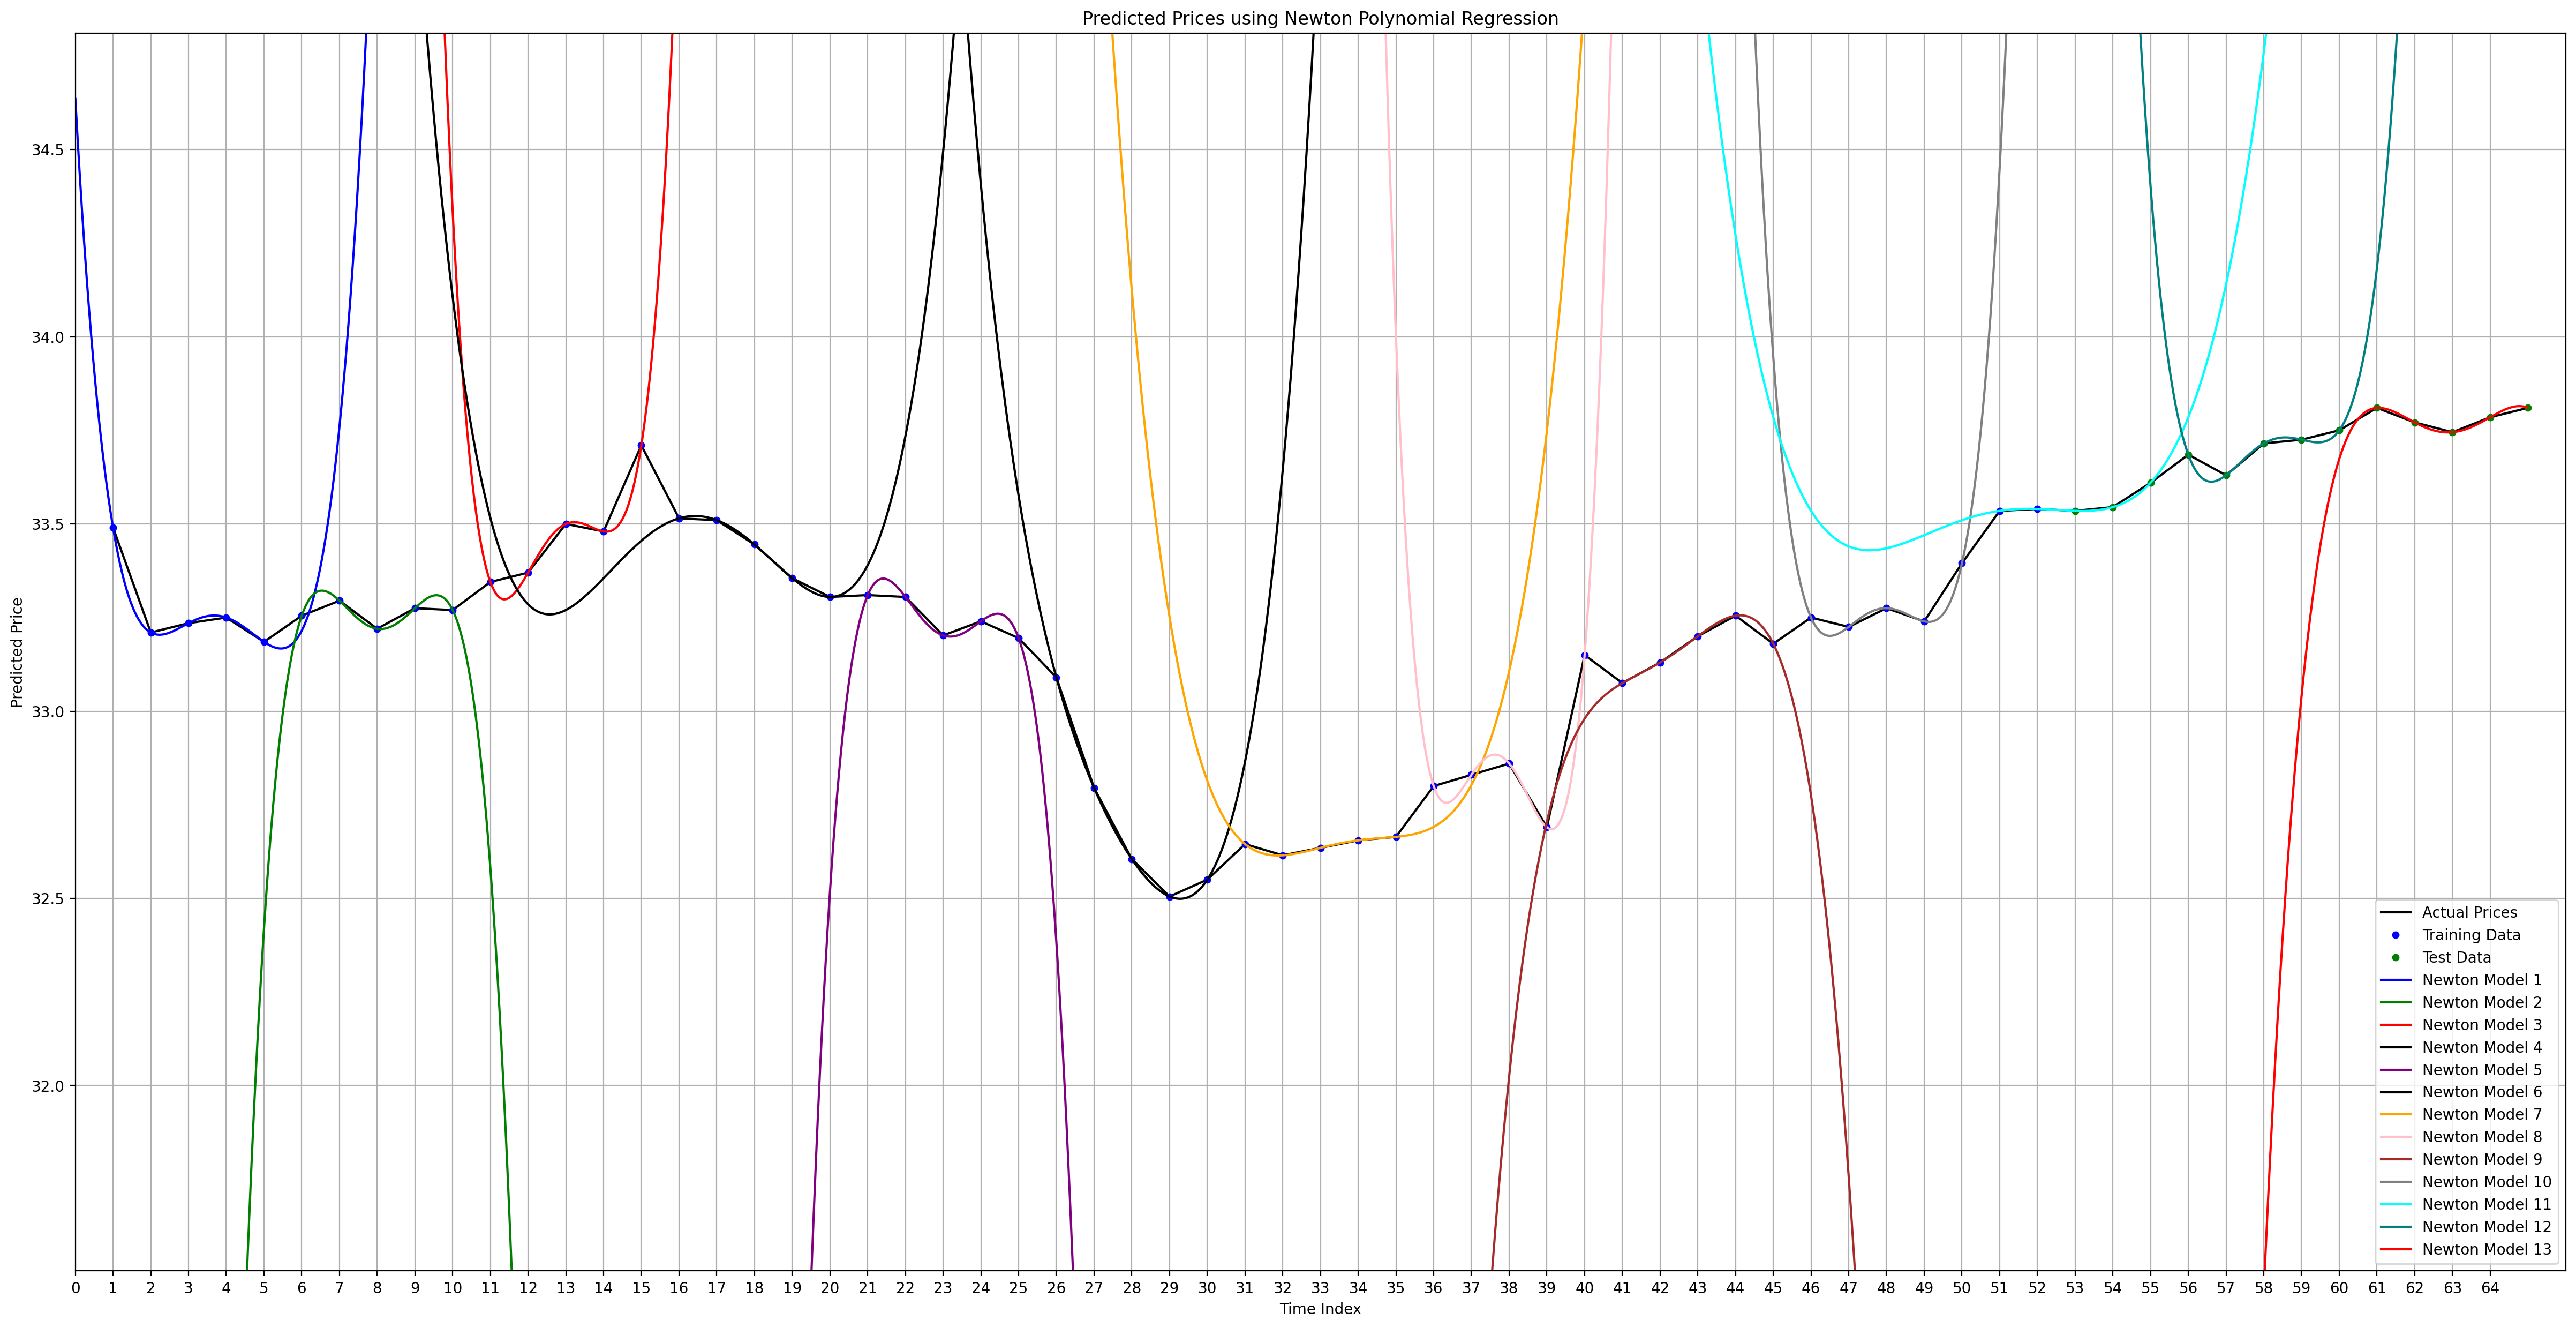

Prediction for time index 6 using Newton Model 1: 33.21501922607422 vs actual price at time index 6: 33.255001068115234
Prediction for time index 11 using Newton Model 2: 32.58000946044922 vs actual price at time index 11: 33.345001220703125
Prediction for time index 16 using Newton Model 3: 35.2450065612793 vs actual price at time index 16: 33.51499938964844
Prediction for time index 21 using Newton Model 4: 33.390010833740234 vs actual price at time index 21: 33.310001373291016
Prediction for time index 26 using Newton Model 5: 32.382991790771484 vs actual price at time index 26: 33.09000015258789
Prediction for time index 31 using Newton Model 6: 32.864990234375 vs actual price at time index 31: 32.64500045776367
Prediction for time index 36 using Newton Model 7: 32.69098663330078 vs actual price at time index 36: 32.79999923706055
Prediction for time index 41 using Newton Model 8: 36.10001754760742 vs actual price at time index 41: 33.07500076293945
Prediction for time index 46 usi

In [52]:
# Διαμοιρασμός σε ίσα κομμάτια με 5 χρονικά σημεία το καθένα
time_spaces = np.zeros((int(len(time)/5), 5))
for i in range(0, int(len(time)/5)):
    for j in range(0, 5):
        time_spaces[i][j] = time[i*5+j]

# Υπολογισμός συντελεστών διηρημένων διαφορών
coeff = np.zeros((int(len(time)/5), 5))
for i in range(0, int(len(time)/5)):
    coeff[i][:] = DivDiffCoeff(time_spaces[i], prices[i*5:i*5+5])

# Δημιουργία πίνακα πολυωνύμων Newton
time_new = np.arange(0, len(time), 0.01)    
model = [
    NewtonInterpolationPoly(time_new, time_spaces[i], coeff[i]) for i in range(0, int(len(time)/5))
]

# Δημιουργία γραφήματος με τα πολυώνυμα που δημιουργήθηκαν
plt.figure(figsize=(30,15), dpi=200)
plt.plot(time, prices, label='Actual Prices', color='black')
plt.plot(time_trainingtimes, price_train, 'o', label='Training Data', markersize=4, color='blue')
plt.plot(time_testtimes, price_test, 'o', label='Test Data', markersize=4, color='green')
colors = ['blue', 'green', 'red', 'black', 'purple', 'black', 'orange', 'pink', 'brown', 'gray', 'cyan', 'teal', 'red']
for i in range(0, int(len(time)/5)):
    plt.plot(time_new, model[i], label=f'Newton Model {i+1}', color= colors[i])
plt.legend()
plt.title('Predicted Prices using Newton Polynomial Regression')
plt.xlabel('Time Index')
plt.ylabel('Predicted Price')
plt.xticks(np.arange(0, len(time), step=1))
plt.ylim(np.min(prices)-1, np.max(prices)+1)
plt.xlim(0, len(time)+1)
plt.legend()
plt.grid(True)
plt.show()

prediction_model_Newton = [
    NewtonInterpolationPoly(5*i+1, time_spaces[i-1][:], coeff[i-1][:]) for i in range(1, int(len(time)/5))
]

for i in range(0, len(prediction_model_Newton)):
    print(f"Prediction for time index {5*(i+1)+1} using Newton Model {i+1}: {prediction_model_Newton[i]} vs actual price at time index {5*(i+1)+1}: {prices[5*(i+1)]}")



Υλοποίση μεθόδου Aitken-Neville

In [53]:
def AitkenNevilleInterpolation(input, x, y):
    p = np.zeros((len(y), len(y)))    
    p[:,0] = y
    for i in range(1, len(y)):
        for j in range(1, i+1):
            p[i,j] = -((x[i-j] - input)*p[i, j-1] - (x[i] - input)*p[i-1, j-1]) / (x[i] - x[i-j])
    return p[-1, -1]

5.  Ανίχνευση Ανωμαλιών στα Ιστορικά Δεδομένα-Μέθοδος Aitken-Neville

In [54]:
prediction_model_Aitken = [
    AitkenNevilleInterpolation(5*i+6, time_spaces[i][:], prices[5*i:5*i+5]) for i in range(0, int(len(time)/5))
]

for i in range(0, len(prediction_model_Aitken)-1):
    print(f"Prediction for time index {5*i+6} using Aitken Model {i+1}: {prediction_model_Aitken[i]} vs actual price at time index {5*i+6}: {prices[5*i+5]}")
    

Prediction for time index 6 using Aitken Model 1: 33.21501922607422 vs actual price at time index 6: 33.255001068115234
Prediction for time index 11 using Aitken Model 2: 32.58000946044922 vs actual price at time index 11: 33.345001220703125
Prediction for time index 16 using Aitken Model 3: 35.2450065612793 vs actual price at time index 16: 33.51499938964844
Prediction for time index 21 using Aitken Model 4: 33.390010833740234 vs actual price at time index 21: 33.310001373291016
Prediction for time index 26 using Aitken Model 5: 32.382991790771484 vs actual price at time index 26: 33.09000015258789
Prediction for time index 31 using Aitken Model 6: 32.864990234375 vs actual price at time index 31: 32.64500045776367
Prediction for time index 36 using Aitken Model 7: 32.69098663330078 vs actual price at time index 36: 32.79999923706055
Prediction for time index 41 using Aitken Model 8: 36.10001754760742 vs actual price at time index 41: 33.07500076293945
Prediction for time index 46 usi

Απάντηση Ερώτησης Θεωρείας Άσκησης 5:

Το Δυναμικό Κατώφλι Ανωμαλίας ορίστηκε ως δ = 0.05 * range + 0.5 * σ. Το range, που είναι η θετική διαφορά μέγιστης-ελαχιστης τιμής, όπως και η διασπορά σ, μέσω του δικού τους ορισμού επηρεάζονται από τη μεταβλητότητα των τιμών του συνόλου. Ένα ευμετάβλητο σύνολο, θα κάνει το range του συνόλου και τη διασπορα σ του να είναι μεγάλα, οπότε το κατώφλι ανωμαλίας θα είναι μεγάλο στο σύνολο αυτό. Αντίστοιχα, ένα πιο σταθερό μοντέλο θα έχει μικρότερα range και σ, οπότε θα έχει μικρότερο κατώφλι δ. 
Σε ένα πιο ευμετάβλητο σύνολο, το range, ενώ πιθανόν μεγάλο, θα επηρεάζει σε πολύ μικρότερο βαθμό το δ, αφού το σ είναι αυτό το οποίο αυξάνεται περισσότερο από την αυξημένη μεταβλητότητα. Έτσι, θα έχω πολύ μεγάλο δ, πράγμα που δυσκολεύει την ανίχνευση ανωμαλιων στο σύνολο. Μια λύση σε αυτό θα ήταν ο πολλαπλασιασμός του σ στον ορισμό του δ με έναν μικρότερο συντελεστή (τωρινός συντελεστής: 0.5).